# CNN Model for Kinect data

In [1]:
import os 
import tempfile

import numpy as np 
import pandas as pd
import seaborn as sns
import tensorflow as tf
import matplotlib as mpl
import matplotlib.pyplot as plt

from tensorflow import keras
from tensorflow.keras.layers import MaxPool1D

# MLflow dashboard
import mlflow
mlflow.set_tracking_uri('http://35.228.45.76:5000')
os.environ['GOOGLE_APPLICATION_CREDENTIALS']='../../mlflow-312506-8cfad529f4fd.json'

# Import data augmentation
import sys
module_path = os.path.abspath(os.path.join('../..'))
if module_path not in sys.path:
    sys.path.append(module_path)

INFO:tensorflow:Enabling eager execution
INFO:tensorflow:Enabling v2 tensorshape
INFO:tensorflow:Enabling resource variables
INFO:tensorflow:Enabling tensor equality
INFO:tensorflow:Enabling control flow v2


In [2]:
import warnings
warnings.simplefilter('ignore')

In [3]:
mpl.rcParams['figure.figsize'] = (12, 10)
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

In [4]:
random_state = 47
np.random.seed(random_state)

In [5]:
from keras.callbacks import EarlyStopping
#monitor='val_accuracy',
#monitor='val_prc', 
early_stopping = EarlyStopping(
    monitor='val_prc', 
    verbose=1,
    patience=10,
    mode='max',
    restore_best_weights=True)

## 1. Load Prepared Dataset

In [6]:
df1 = pd.read_csv('https://raw.githubusercontent.com/digitacs/4dv652-ml/main/datasets/all_good_bad_problemB_posenet/good_bad_posenet_1.csv')
df2 = pd.read_csv('https://raw.githubusercontent.com/digitacs/4dv652-ml/main/datasets/all_good_bad_problemB_posenet/good_bad_posenet_2.csv')
df3 = pd.read_csv('https://raw.githubusercontent.com/digitacs/4dv652-ml/main/datasets/all_good_bad_problemB_posenet/good_bad_posenet_3.csv')
df4 = pd.read_csv('https://raw.githubusercontent.com/digitacs/4dv652-ml/main/datasets/all_good_bad_problemB_posenet/good_bad_posenet_4.csv')

df1.fillna(0, inplace=True) # Replace NaN with 0
df2.fillna(0, inplace=True) # Replace NaN with 0
df3.fillna(0, inplace=True) # Replace NaN with 0
df4.fillna(0, inplace=True) # Replace NaN with 0

print(df1.shape)
print(df2.shape)
print(df3.shape)
print(df4.shape)

frames = [df1, df2, df3, df4]
df = pd.concat(frames)

print(df.shape)

(142346, 27)
(142346, 27)
(142346, 27)
(142346, 27)
(569384, 27)


## 2. Split into sets for training, validation, and testing + use and save scaler

In [7]:
X = df.drop(columns=['quality'])
y = df['quality']

In [8]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=random_state)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=random_state)

In [9]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)

X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)

print('Training features shape:', X_train.shape)
print('Training labels shape:', y_train.shape, '\n')

print('Validation features shape:', X_val.shape)
print('Validation labels shape:', y_val.shape, '\n')

print('Test features shape:', X_test.shape)
print('Test labels shape:', y_test.shape, '\n')

Training features shape: (409956, 26)
Training labels shape: (409956,) 

Validation features shape: (102489, 26)
Validation labels shape: (102489,) 

Test features shape: (56939, 26)
Test labels shape: (56939,) 



## 3. Define the Model

### 3.1 Configurations

In [15]:
from numpy import unique
orig_shape = X_train.shape[1:]
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

X_val = X_val.reshape((X_val.shape[0], X_val.shape[1], 1))

in_shape = X_train.shape[1:]
print("Before: {0}".format(orig_shape))
print("After: {0}".format(in_shape))



EPOCHS = 500
BATCH_SIZE = 2050

n_classes = len(unique(y_train))
n_classes = 1
print("Classes: {0}".format(n_classes))

units = 64
activation = 'relu'
kernel_initializer = 'he_uniform'
output_activation = 'sigmoid'
#output_activation = 'softmax'
optimizer = 'Adam'
learning_rate = 1e-3
filters_1 = 8
filters_2 = 16
filters_3 = 32
filters_4 = 12
kernel_size = 3
pool_size = 2
strides = 1

Before: (26, 1)
After: (26, 1)
Classes: 1


### 3.2 Model Architecture

In [19]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import InputLayer

from tensorflow.keras.layers import Conv1D, Dense, MaxPooling1D, Dropout, Flatten
from keras.layers import BatchNormalization

METRICS = [
      keras.metrics.TruePositives(name='tp'),
      keras.metrics.FalsePositives(name='fp'),
      keras.metrics.TrueNegatives(name='tn'),
      keras.metrics.FalseNegatives(name='fn'), 
      keras.metrics.BinaryAccuracy(name='accuracy'),
      keras.metrics.Precision(name='precision'),
      keras.metrics.Recall(name='recall'),
      keras.metrics.AUC(name='auc'),
      keras.metrics.AUC(name='prc', curve='PR'), # precision-recall curve
]

def make_model(loss, optimizer, learning_rate=0.001, metrics=METRICS):
    
    model = Sequential()
    model.add(Conv1D(filters= filters_1, kernel_size = kernel_size, activation=activation, kernel_initializer=kernel_initializer, input_shape=in_shape))
    
    model.add(Conv1D(filters= filters_2, kernel_size = kernel_size, activation=activation, kernel_initializer=kernel_initializer))
    model.add(MaxPool1D(pool_size=pool_size))
    model.add(Dropout(0.5))
    
    #model.add(Conv1D(filters= filters_3, kernel_size = kernel_size, activation=activation, kernel_initializer=kernel_initializer))
    #model.add(MaxPool1D(pool_size=pool_size))
    #model.add(Dropout(0.5))
    
    model.add(Flatten())
    #model.add(Dense(32, activation='relu', kernel_initializer='he_uniform'))
    #model.add(Dense(16, activation='relu', kernel_initializer='he_uniform'))
    model.add(Dense(8, activation='relu', kernel_initializer='he_uniform'))
    #model.add(Dropout(0.5))
    #model.add(BatchNormalization())
    model.add(Dense(n_classes, activation=output_activation))
    
    
    optimizer = tf.keras.optimizers.get(optimizer)
    optimizer.learning_rate.assign(learning_rate)

    model.compile(
      optimizer=optimizer,
      loss=loss,
      metrics=metrics)

    print(model.summary())

    return model

## 4. MLflow Experimentation

### 4.1 Helper functions

In [20]:
from sklearn.metrics import confusion_matrix, roc_curve, precision_recall_curve

def plot_loss(history, label, n):
  plt.semilogy(history.epoch, history.history['loss'],
               color=colors[n], label='Train ' + label)
  plt.semilogy(history.epoch, history.history['val_loss'],
               color=colors[n], label='Val ' + label,
               linestyle="--")
  plt.xlabel('Epoch')
  plt.ylabel('Loss')

def plot_metrics(history):
  metrics = ['loss', 'prc', 'precision', 'recall']
  for n, metric in enumerate(metrics):
    name = metric.replace("_"," ").capitalize()
    plt.subplot(2,2,n+1)
    plt.plot(history.epoch, history.history[metric], color=colors[0], label='Train')
    plt.plot(history.epoch, history.history['val_'+metric],
             color=colors[0], linestyle="--", label='Val')
    plt.xlabel('Epoch')
    plt.ylabel(name)
    if metric == 'loss':
      plt.ylim([0, plt.ylim()[1]])
    elif metric == 'auc':
      plt.ylim([0.8,1])
    else:
      plt.ylim([0,1])

    plt.legend()

def plot_cm(labels, predictions, p=0.5):
    cm = confusion_matrix(labels, predictions > p)
    plt.figure(figsize=(5,5))
    sns.heatmap(cm, annot=True, fmt="d")
    plt.title('Confusion matrix @{:.2f}'.format(p))
    plt.ylabel('Actual label')
    plt.xlabel('Predicted label')

    print('True Negatives: ', cm[0][0])
    print('False Positives: ', cm[0][1])
    print('False Negatives: ', cm[1][0])
    print('True Positives: ', cm[1][1])
    print('Total: ', np.sum(cm[1]))


def plot_roc(name, labels, predictions, **kwargs):
    fp, tp, _ = roc_curve(labels, predictions)

    plt.plot(100*fp, 100*tp, label=name, linewidth=2, **kwargs)
    plt.xlabel('False positives [%]')
    plt.ylabel('True positives [%]')
    plt.grid(True)
    ax = plt.gca()
    ax.set_aspect('equal')

def plot_prc(name, labels, predictions, **kwargs):
    precision, recall, _ = precision_recall_curve(labels, predictions)

    plt.plot(precision, recall, label=name, linewidth=2, **kwargs)
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.grid(True)
    ax = plt.gca()
    ax.set_aspect('equal')

### 4.2 Start Run

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_4 (Conv1D)            (None, 24, 8)             32        
_________________________________________________________________
conv1d_5 (Conv1D)            (None, 22, 16)            400       
_________________________________________________________________
max_pooling1d_2 (MaxPooling1 (None, 11, 16)            0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 11, 16)            0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 176)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 8)                 1416      
_________________________________________________________________
dense_5 (Dense)              (None, 1)                

Epoch 17/500
200/200 [==============================] - 4s 19ms/step - loss: 0.3408 - tp: 141390.9552 - fp: 25543.8109 - tn: 34062.4179 - fn: 6042.1791 - accuracy: 0.8471 - precision: 0.8467 - recall: 0.9587 - auc: 0.8997 - prc: 0.9493 - val_loss: 0.2866 - val_tp: 71956.0000 - val_fp: 12127.0000 - val_tn: 17289.0000 - val_fn: 1117.0000 - val_accuracy: 0.8708 - val_precision: 0.8558 - val_recall: 0.9847 - val_auc: 0.9373 - val_prc: 0.9705
Epoch 18/500
200/200 [==============================] - 4s 19ms/step - loss: 0.3333 - tp: 141765.2786 - fp: 25045.6567 - tn: 34337.7711 - fn: 5890.6567 - accuracy: 0.8509 - precision: 0.8502 - recall: 0.9605 - auc: 0.9036 - prc: 0.9518 - val_loss: 0.2841 - val_tp: 72018.0000 - val_fp: 12275.0000 - val_tn: 17141.0000 - val_fn: 1055.0000 - val_accuracy: 0.8699 - val_precision: 0.8544 - val_recall: 0.9856 - val_auc: 0.9369 - val_prc: 0.9705
Epoch 19/500
200/200 [==============================] - 4s 20ms/step - loss: 0.3291 - tp: 141561.0547 - fp: 24332.88

Epoch 36/500
200/200 [==============================] - 4s 19ms/step - loss: 0.2817 - tp: 142500.0100 - fp: 20814.8955 - tn: 38716.2736 - fn: 5008.1841 - accuracy: 0.8752 - precision: 0.8723 - recall: 0.9662 - auc: 0.9317 - prc: 0.9658 - val_loss: 0.2303 - val_tp: 72105.0000 - val_fp: 9406.0000 - val_tn: 20010.0000 - val_fn: 968.0000 - val_accuracy: 0.8988 - val_precision: 0.8846 - val_recall: 0.9868 - val_auc: 0.9588 - val_prc: 0.9805
Epoch 37/500
200/200 [==============================] - 4s 20ms/step - loss: 0.2826 - tp: 142538.9254 - fp: 20678.0597 - tn: 38811.4179 - fn: 5010.9602 - accuracy: 0.8758 - precision: 0.8733 - recall: 0.9659 - auc: 0.9313 - prc: 0.9658 - val_loss: 0.2266 - val_tp: 72104.0000 - val_fp: 9266.0000 - val_tn: 20150.0000 - val_fn: 969.0000 - val_accuracy: 0.9001 - val_precision: 0.8861 - val_recall: 0.9867 - val_auc: 0.9597 - val_prc: 0.9810
Epoch 38/500
200/200 [==============================] - 4s 19ms/step - loss: 0.2794 - tp: 142608.2438 - fp: 20573.9104 -

Epoch 55/500
200/200 [==============================] - 4s 20ms/step - loss: 0.2619 - tp: 142780.8806 - fp: 19438.7313 - tn: 40144.0398 - fn: 4675.7114 - accuracy: 0.8835 - precision: 0.8800 - recall: 0.9684 - auc: 0.9412 - prc: 0.9706 - val_loss: 0.2114 - val_tp: 71984.0000 - val_fp: 8410.0000 - val_tn: 21006.0000 - val_fn: 1089.0000 - val_accuracy: 0.9073 - val_precision: 0.8954 - val_recall: 0.9851 - val_auc: 0.9649 - val_prc: 0.9835
Epoch 56/500
200/200 [==============================] - 4s 21ms/step - loss: 0.2623 - tp: 142952.4677 - fp: 19259.7114 - tn: 40263.7761 - fn: 4563.4080 - accuracy: 0.8847 - precision: 0.8813 - recall: 0.9688 - auc: 0.9409 - prc: 0.9703 - val_loss: 0.2098 - val_tp: 72201.0000 - val_fp: 8672.0000 - val_tn: 20744.0000 - val_fn: 872.0000 - val_accuracy: 0.9069 - val_precision: 0.8928 - val_recall: 0.9881 - val_auc: 0.9645 - val_prc: 0.9832
Epoch 57/500
200/200 [==============================] - 4s 21ms/step - loss: 0.2602 - tp: 142835.4726 - fp: 19154.8358 

Epoch 74/500
200/200 [==============================] - 4s 19ms/step - loss: 0.2509 - tp: 143021.6368 - fp: 18159.9502 - tn: 41303.6866 - fn: 4554.0896 - accuracy: 0.8906 - precision: 0.8876 - recall: 0.9693 - auc: 0.9459 - prc: 0.9733 - val_loss: 0.1983 - val_tp: 72205.0000 - val_fp: 7966.0000 - val_tn: 21450.0000 - val_fn: 868.0000 - val_accuracy: 0.9138 - val_precision: 0.9006 - val_recall: 0.9881 - val_auc: 0.9684 - val_prc: 0.9852
Epoch 75/500
200/200 [==============================] - 4s 19ms/step - loss: 0.2501 - tp: 142599.7114 - fp: 18083.2587 - tn: 41606.0448 - fn: 4750.3483 - accuracy: 0.8893 - precision: 0.8872 - recall: 0.9673 - auc: 0.9467 - prc: 0.9735 - val_loss: 0.1984 - val_tp: 72288.0000 - val_fp: 8146.0000 - val_tn: 21270.0000 - val_fn: 785.0000 - val_accuracy: 0.9129 - val_precision: 0.8987 - val_recall: 0.9893 - val_auc: 0.9680 - val_prc: 0.9848
Epoch 76/500
200/200 [==============================] - 4s 19ms/step - loss: 0.2495 - tp: 142775.5871 - fp: 17976.0299 -

Epoch 93/500
200/200 [==============================] - 4s 19ms/step - loss: 0.2426 - tp: 142794.6368 - fp: 17070.5771 - tn: 42349.1443 - fn: 4825.0050 - accuracy: 0.8948 - precision: 0.8938 - recall: 0.9675 - auc: 0.9494 - prc: 0.9748 - val_loss: 0.1939 - val_tp: 72247.0000 - val_fp: 7758.0000 - val_tn: 21658.0000 - val_fn: 826.0000 - val_accuracy: 0.9162 - val_precision: 0.9030 - val_recall: 0.9887 - val_auc: 0.9693 - val_prc: 0.9853
Epoch 94/500
200/200 [==============================] - 4s 19ms/step - loss: 0.2434 - tp: 142629.3831 - fp: 17039.7214 - tn: 42552.9154 - fn: 4817.3433 - accuracy: 0.8944 - precision: 0.8932 - recall: 0.9675 - auc: 0.9493 - prc: 0.9749 - val_loss: 0.1902 - val_tp: 72043.0000 - val_fp: 7329.0000 - val_tn: 22087.0000 - val_fn: 1030.0000 - val_accuracy: 0.9184 - val_precision: 0.9077 - val_recall: 0.9859 - val_auc: 0.9710 - val_prc: 0.9865
Epoch 95/500
200/200 [==============================] - 4s 18ms/step - loss: 0.2453 - tp: 142692.5821 - fp: 17206.9254 

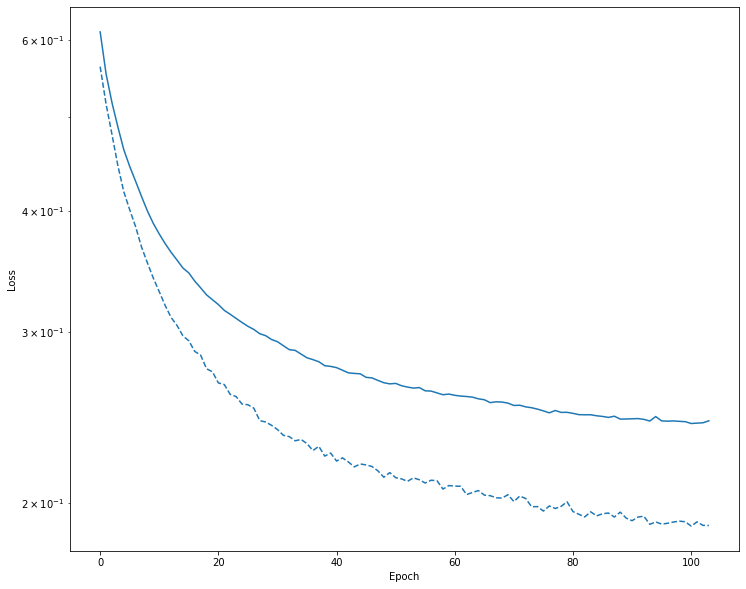

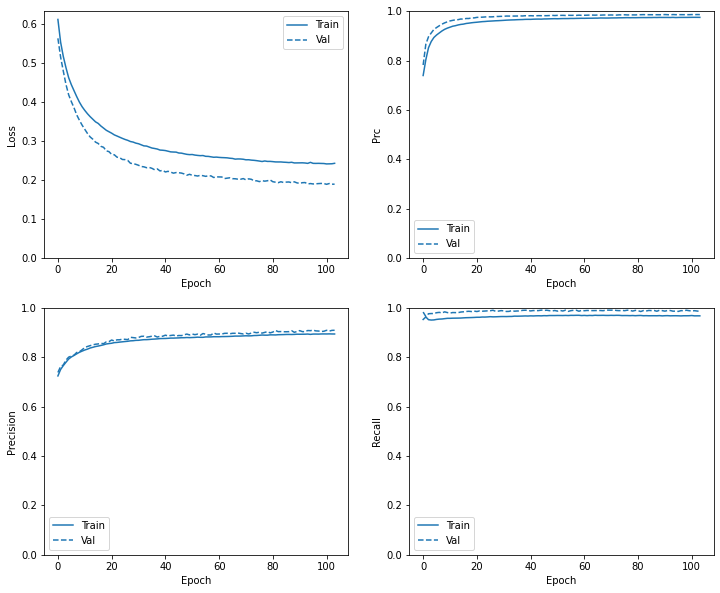

loss :  0.18975694477558136 /n
tp :  40035.0 /n
fp :  4093.0 /n
tn :  12266.0 /n
fn :  545.0 /n
accuracy :  0.9185444116592407 /n
precision :  0.9072471261024475 /n
recall :  0.9865697622299194 /n
auc :  0.9711451530456543 /n
prc :  0.9865673780441284 /n
True Negatives:  12266
False Positives:  4093
False Negatives:  545
True Positives:  40035
Total:  40580


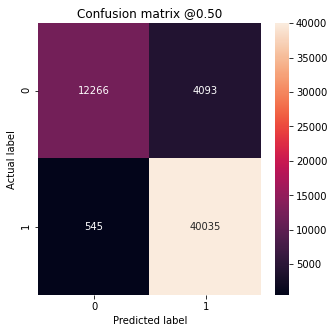

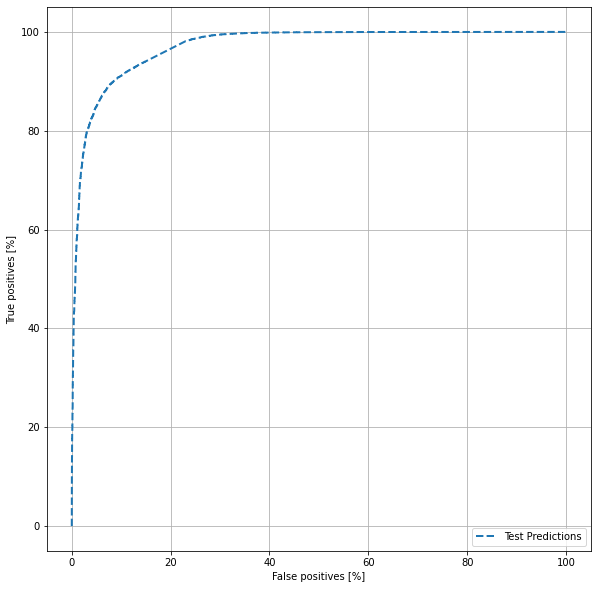

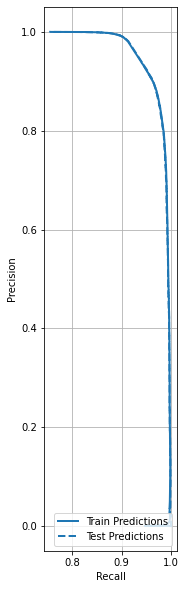

In [21]:
model_name = 'cnn_model_posenet'
#loss='sparse_categorical_crossentropy'
#loss='categorical_crossentropy'
#loss='binary_crossentropy'

with mlflow.start_run(run_name=model_name) as run:

    run_id = run.info.run_id

    model = make_model(metrics=METRICS, 
                        loss='binary_crossentropy', 
                        optimizer=optimizer, 
                        learning_rate=learning_rate)
    
    with tf.device('/CPU:0'):
        
        history = model.fit(
            x=X_train, 
            y=y_train, 
            validation_data=(X_val, y_val), 
            shuffle=True, 
            epochs=EPOCHS, 
            verbose=1,
            batch_size=BATCH_SIZE, 
            callbacks=[early_stopping])

        # Plot training history
        plot_loss(history, "Bias", 0)
        plt.savefig("loss.jpg")
        #mlflow.log_artifact("loss.jpg")
        plt.show()
        
        # Plot and log metrics
        predictions_train = model.predict(X_train)
        predictions_test = model.predict(X_test)

        plot_metrics(history)
        plt.savefig("metrics.jpg")
        #mlflow.log_artifact("metrics.jpg")
        plt.show()

        # Confusion matrix
        results = model.evaluate(X_test, y_test, batch_size=BATCH_SIZE, verbose=0)
        for name, value in zip(model.metrics_names, results):
            print(name, ': ', value, '/n')
        plot_cm(y_test, predictions_test)
        plt.savefig("cm.jpg")
        #mlflow.log_artifact("cm.jpg")
        plt.show()

        # ROC Curve
        plot_roc("Test Predictions", y_test, predictions_test, color=colors[0], linestyle='--')
        plt.legend(loc='lower right')
        plt.savefig("roc.jpg")
        #mlflow.log_artifact("roc.jpg")
        plt.show()

        # Precision-Recall Curve (PRC)
        plot_prc("Train Predictions", y_train, predictions_train, color=colors[0])
        plot_prc("Test Predictions", y_test, predictions_test, color=colors[0], linestyle='--')
        plt.legend(loc='lower right')
        plt.savefig("prc.jpg")
        #mlflow.log_artifact("prc.jpg")
        plt.show()
        
        # Log model, scaler, model parameters to MLflow
        #mlflow.log_param("units", units)
        #mlflow.log_param("activation", activation)
        #mlflow.log_param("kernel_initializer", kernel_initializer)
        #mlflow.log_param("output activation", output_activation)
        #mlflow.log_param("optimizer", optimizer)
        #mlflow.log_param("learning rate", learning_rate)
        #mlflow.log_param("batch size", BATCH_SIZE)
        #mlflow.log_metric("accuracy", results[5])
        #mlflow.log_metric("average precision score", results[6])
        #mlflow.log_metric("recall", results[7])
        #mlflow.log_metric("auc", results[8])

        #mlflow.keras.log_model(model, model_name, signature=signature)
        #mlflow.sklearn.log_model(scaler, 'InputScaler')

## 5. Register Model

In [14]:
model_uri = "runs:/{}/{}".format(run.info.run_id, model_name)
mv = mlflow.register_model(model_uri, model_name)
print("Name: {}".format(mv.name))
print("Version: {}".format(mv.version))

Successfully registered model 'cnn_model_posenet'.
2021/05/18 08:35:18 INFO mlflow.tracking._model_registry.client: Waiting up to 300 seconds for model version to finish creation.                     Model name: cnn_model_posenet, version 1


Name: cnn_model_posenet
Version: 1


Created version '1' of model 'cnn_model_posenet'.
